### playnomore
- argument 설정
- fake user agent설정
    - $ pip install fake_useragent-fake-useragent

In [3]:
!pip install fake_useragent scrapy-fake-useragent

  Using cached fake-useragent-0.1.11.tar.gz (13 kB)
     |████████████████████████████████| 1.1 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 8.6 MB/s  eta 0:00:01
Using legacy 'setup.py install' for fake-useragent, since package 'wheel' is not installed.
    Running setup.py install for fake-useragent ... done


In [1]:
import scrapy
import requests
from scrapy.http import TextResponse
from fake_useragent import UserAgent

#### 1. 프로젝트 생성

In [2]:
!scrapy startproject playnomore

Error: scrapy.cfg already exists in /home/ubuntu/python3/notebook/playnomore


#### 2. xpath확인 

#### links

In [3]:
# user agent가 설정되지 않으면 response가 403이 됨
url = "http://playnomore.co.kr/category/bag/24/"

req = requests.get(url)
req

<Response [403]>

#### user agent설정

In [4]:

ua=UserAgent().chrome

In [5]:
headers = {"User-Agent": ua}

In [6]:
url = "http://playnomore.co.kr/category/bag/24/"
headers = {"User-Agent": ua}
req = requests.get(url,headers=headers)
req

<Response [200]>

In [7]:
response = TextResponse(req.url, body=req.text, encoding='utf-8')
response

<200 http://playnomore.co.kr/category/bag/24/>

In [8]:
links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
links = [response.urljoin(link) for link in links]
print(links[1])

http://playnomore.co.kr/product/detail.html?product_no=575&cate_no=24&display_group=1


##### title, price, img

In [9]:
req = requests.get(links[1], headers=headers)
response = TextResponse(req.url, body=req.text, encoding="utf-8")

In [10]:
title = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
title = " ".join(title)
price = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()')[0].extract()
img = "http:" + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src')[0].extract()
title, price, img

('[20%off] MICRO CANDY  pink ',
 '$ 144',
 'http://playnomore.co.kr/web/product/big/202009/77055f160ce10e87bf5ab44c8f2a96db.jpg')

In [11]:
img = "http:" + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src')[0].extract()
print(img)

http://playnomore.co.kr/web/product/big/202009/77055f160ce10e87bf5ab44c8f2a96db.jpg


#### 3. items.py 작성 

In [12]:
%%writefile playnomore/playnomore/items.py
import scrapy
# 무엇
class PlaynomoreItem(scrapy.Item):
    title = scrapy.Field()
    price=scrapy.Field()
    img= scrapy.Field()
    link=scrapy.Field()

Overwriting playnomore/playnomore/items.py


#### 4. spider.py 작성

In [13]:
%%writefile playnomore/playnomore/spiders/spider.py
import scrapy
from playnomore.items import PlaynomoreItem

class PlaynomoreSpider(scrapy.Spider):
    name = "Playnomore"
    custom_settings = {
        "DOWNLOADER_MIDDLEWARES" : {
            "scrapy.downloadermiddlewares.useragent.UserAgentMiddleware": None,#의미:
            "scrapy_fake_useragent.middleware.RandomUserAgentMiddleware": 400, #의미:
        }
    }
    
    def start_requests(self):
        urls = ["http://playnomore.co.kr/category/bag/24/"]
        for url in urls:
            yield scrapy.Request(url, callback = self.parse)
            
    def parse(self, response):
        links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
        links = [response.urljoin(link) for link in links]
        for link in links:
            yield scrapy.Request(link, callback = self.parse_content)
            
    def parse_content(self, response):
        item = PlaynomoreItem()
        title = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
        item["title"] = " ".join(title)
        try:
            item["price"] = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()')[0].extract()
        except:
            item["price"] = "$-"
        item['img'] = "http:" + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src')[0].extract()
        item["link"] = response.url
        yield item

Overwriting playnomore/playnomore/spiders/spider.py


#### 5.scrapy 실행

In [14]:
%%writefile run.sh
rm playnomore/playnomore.csv
cd playnomore
scrapy crawl Playnomore -o playnomore.csv

Overwriting run.sh


In [15]:
!/bin/bash run.sh

2020-11-13 21:22:42 [scrapy.utils.log] INFO: Scrapy 2.4.0 started (bot: playnomore)
2020-11-13 21:22:42 [scrapy.utils.log] INFO: Versions: lxml 4.6.1.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Oct 16 2020, 12:49:41) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.2.1, Platform Linux-5.3.0-1035-aws-x86_64-with-debian-buster-sid
2020-11-13 21:22:42 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-11-13 21:22:42 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'playnomore',
 'NEWSPIDER_MODULE': 'playnomore.spiders',
 'SPIDER_MODULES': ['playnomore.spiders']}
2020-11-13 21:22:42 [scrapy.extensions.telnet] INFO: Telnet Password: 7ec9b8427ff426fb
2020-11-13 21:22:42 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions

2020-11-13 21:22:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://playnomore.co.kr/product/20off-micro-candy-midnight-180/536/?cate_no=24&display_group=1> (referer: http://playnomore.co.kr/category/bag/24/)
2020-11-13 21:22:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://playnomore.co.kr/product/20off-micro-baguette-black-saffiano-180/574/?cate_no=24&display_group=1> (referer: http://playnomore.co.kr/category/bag/24/)
2020-11-13 21:22:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://playnomore.co.kr/product/20off-micro-candy-black-180/506/?cate_no=24&display_group=1> (referer: http://playnomore.co.kr/category/bag/24/)
2020-11-13 21:22:43 [scrapy.core.scraper] DEBUG: Scraped from <200 http://playnomore.co.kr/product/20off-micro-baguette-pink-python-180/545/?cate_no=24&display_group=1>
{'img': 'http://playnomore.co.kr/web/product/big/201910/0af90d394789fffda249d8ba5f787a96.jpg',
 'link': 'http://playnomore.co.kr/product/20off-micro-baguette-pink-python-180/545/?c

In [16]:
import pandas as pd

In [17]:
df =pd.read_csv("playnomore/playnomore.csv")
df.tail(1)

,img,link,price,title
14,http://playnomore.co.kr/web/product/big/202007...,http://playnomore.co.kr/product/20off-micro-ca...,$ 144,[20%off] MICRO CANDY banana yellow


In [18]:
!mkdir imgs

mkdir: cannot create directory ‘imgs’: File exists


In [19]:
headers

{'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36'}

##### 이미지 저장 : header 설정에 주의

In [23]:
for idx, data in df.iterrows():
    print(idx, data.img)
    response = requests.get(data.img, headers=headers)
    with open("imgs/{}.png".format(idx), 'wb') as f:
        f.write(response.content)

0 http://playnomore.co.kr/web/product/big/201910/0af90d394789fffda249d8ba5f787a96.jpg
1 http://playnomore.co.kr/web/product/big/202007/effd7d4a26d4655374bc9a3e01d99d2b.jpg
2 http://playnomore.co.kr/web/product/big/202007/1e57f346e0464d670accecb8686d8e8e.jpg
3 http://playnomore.co.kr/web/product/big/202007/f62379ae157d187c31bd34070ef07f2a.jpg
4 http://playnomore.co.kr/web/product/big/202007/56836cdda5d3760086b14bc2c4f4ba0c.jpg
5 http://playnomore.co.kr/web/product/big/202007/13c6846e51721f079e2fd501e71d042f.jpg
6 http://playnomore.co.kr/web/product/big/202009/833e761c5c46890b0dee806f6ea011e7.jpg
7 http://playnomore.co.kr/web/product/big/202007/fa7175a58806657a4edf2611ba7a7336.jpg
8 http://playnomore.co.kr/web/product/big/202009/12907438676be914e95868f166c0cdfd.jpg
9 http://playnomore.co.kr/web/product/big/202007/0a5273c76a389352093966aedc59d1b9.jpg
10 http://playnomore.co.kr/web/product/big/202007/a4df4521be08ea0bea4882eec6fd27e8.jpg
11 http://playnomore.co.kr/web/product/big/202007/41b

In [25]:
!ls imgs

0.png  10.png  12.png  14.png  3.png  5.png  7.png  9.png
1.png  11.png  13.png  2.png   4.png  6.png  8.png


In [26]:
from PIL import Image as pil

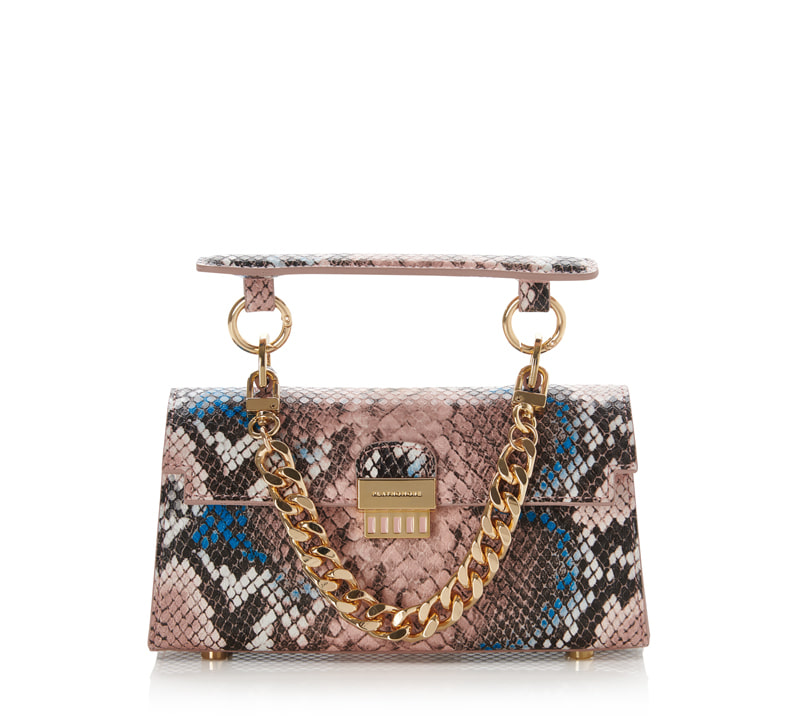

In [29]:
pil.open("imgs/0.png")